In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from tsmom_model import *
import numpy as np
import PPCA_MR3 as p
from datetime import datetime
import statsmodels.formula.api as sm
from linearmodels.asset_pricing import LinearFactorModel

In [2]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [3]:
cleansed=load_amihud_markets_price()

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:158: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:42: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:46: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=250,min_periods=100,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mea

# Presentation to be like "Time Varying Liquidity and Momentum Profits (2015) paper

Rank by deciles, HML (8,9,10) - (1,2,3).  Save monthly returns (equal (risk?) weighted) and if you want to annualized then resample.


Then correlation matrix 
* Overall market vol?
* Market illiquidity (median Amihud through time series)


# Amihud (2002) Annual portfolio sorts

In [5]:
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:273: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:273: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


In [6]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,5)

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:238: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:239: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)].mean(axis=1)


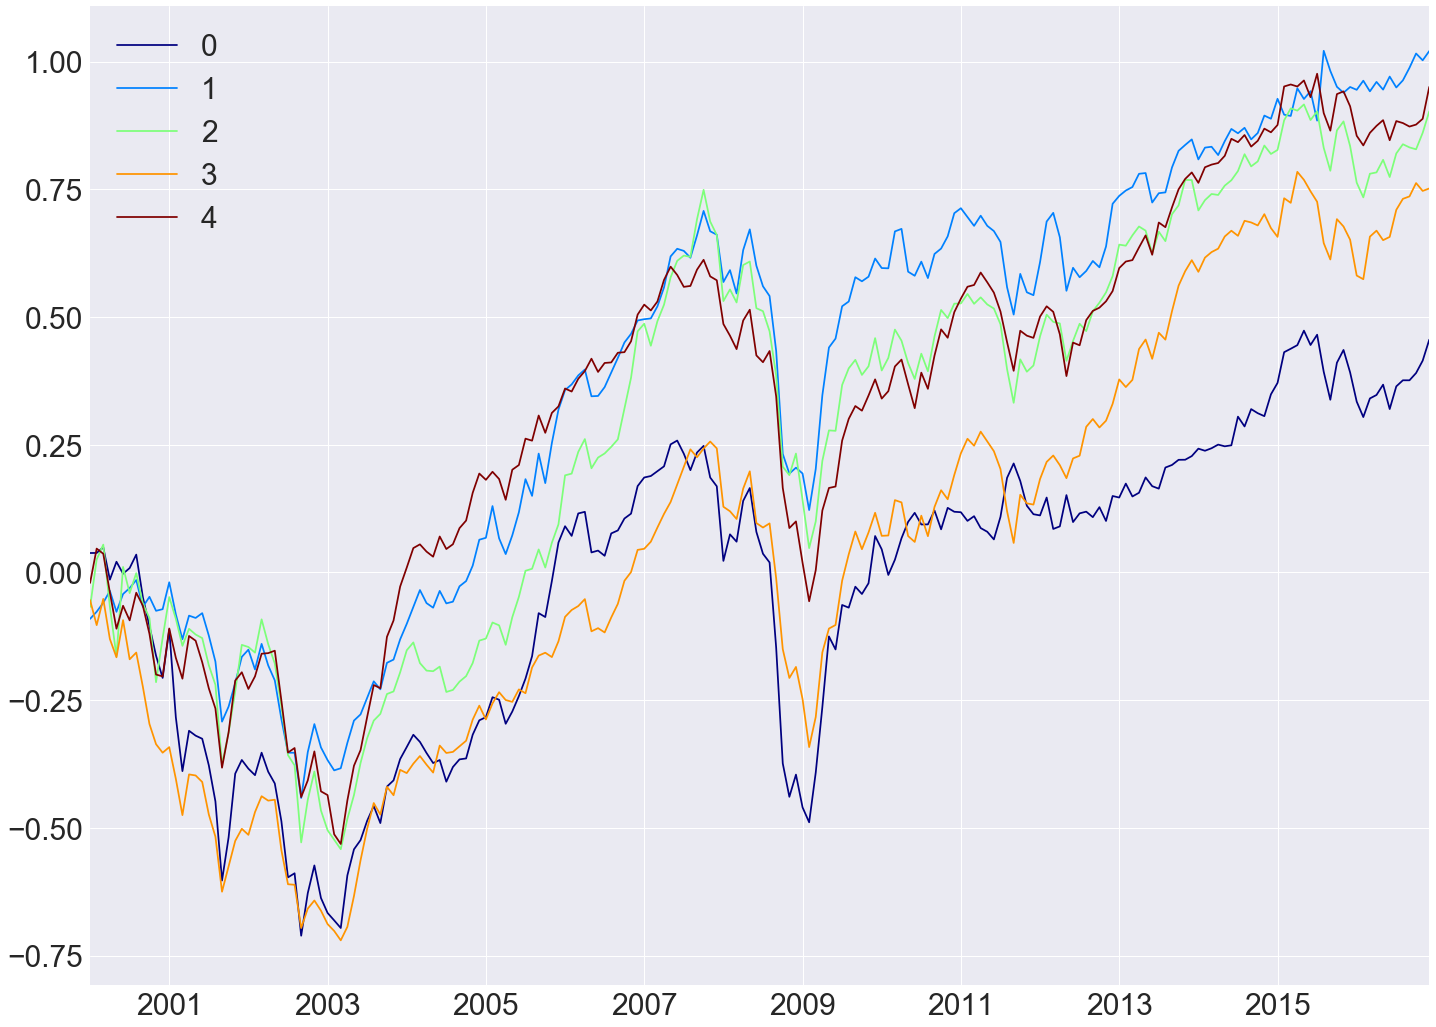

In [7]:
sector_portfolio_sorts['Equities'].cumsum().plot(colormap='jet')

In [8]:
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(labels=sector_zscores[sect].index,axis='index')
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print(sect)

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:273: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:273: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


In [9]:
results_dict={}
results_dict['Risk Premia A-A']=[]
results_dict['Tstats A-A']=[]
sectors=['Equities', 'Commodities', 'Fixed Income']
for sec in sectors:
    factor=pd.DataFrame()
    #factor['Common Factor']=sector_PC[sec][0]
    #factor['Median Sector Amihud']=calc_AR2_resid(amihud[d_map[sec]].median(axis=1).dropna())
    factor['Median Sector Amihud']=amihud[d_map[sec]].median(axis=1).dropna()
    #factor['Median total Amihud']=amihud.median(axis=1).dropna()
    #factor['Mkt-RF']=FF['Mkt-RF']
    ind=sector_portfolio_sorts[sec].shift().dropna().index
    mod=LinearFactorModel(sector_portfolio_sorts[sec].shift().dropna(),factor.loc[ind])
    res=mod.fit(cov_type='kernel')
    results_dict['Risk Premia A-A'].append(res.risk_premia['Median Sector Amihud']*1e12)
    results_dict['Tstats A-A'].append(res.risk_premia_tstats['Median Sector Amihud'])
res_df=pd.DataFrame(results_dict)
res_df.set_axis(labels=sectors,axis=0)

In [10]:
res_df.round(2)

,Risk Premia A-A,Tstats A-A
Equities,-3.15,-0.95
Commodities,-315.24,-0.76
Fixed Income,0.03,0.94


In [11]:
full_res=res_df.copy()

In [12]:
full_res

,Risk Premia A-A,Tstats A-A
Equities,-3.147483,-0.949342
Commodities,-315.237514,-0.761992
Fixed Income,0.033516,0.935134


# Monthly Amihud values

In [13]:
mon_amihud=read_monthly(amihud=True)

In [14]:
results_dict={}
results_dict['Risk Premia A-M']=[]
results_dict['Tstats A-M']=[]
sectors=['Equities', 'Commodities', 'Fixed Income']
for sec in sectors:
    factor=pd.DataFrame()
    #factor['Common Factor']=sector_PC[sec][0]
    factor['Median Sector Amihud']=amihud[d_map[sec]].median(axis=1).dropna()
    factor['Median Sector Amihud']=amihud[d_map[sec]].median(axis=1).dropna()
    #factor['Median total Amihud']=amihud.median(axis=1).dropna()
    #factor['Mkt-RF']=FF['Mkt-RF']
    ind=mon_amihud[sec].shift().dropna().index
    mod=LinearFactorModel(mon_amihud[sec].shift().dropna(),factor.loc[ind])
    res=mod.fit(cov_type='kernel')
    results_dict['Risk Premia A-M'].append(res.risk_premia['Median Sector Amihud']*1e12)
    results_dict['Tstats A-M'].append(res.risk_premia_tstats['Median Sector Amihud'])
res_df=pd.DataFrame(results_dict)
res_df.set_axis(labels=sectors,axis=0)

In [15]:
res_df.round(2).T

,Equities,Commodities,Fixed Income
Risk Premia A-M,-3.39,-271.99,0.08
Tstats A-M,-0.95,-0.96,2.01


In [16]:
full_res=full_res.join(res_df)

# FHT Annual portfolio sorts

In [17]:
FHT=calculate_FHT(cleansed)
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(FHT)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:283: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:284: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:285: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:285: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(

In [18]:
sector_portfolio_sorts_FHT={}
for s in sector_zscores.keys():
    sector_portfolio_sorts_FHT[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,5)

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:238: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:239: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)].mean(axis=1)


In [19]:
results_dict={}
results_dict['Risk Premia F-A']=[]
results_dict['Tstats F-A']=[]
sectors=['Equities', 'Commodities', 'Fixed Income']
for sec in sectors:
    factor=pd.DataFrame()
    #factor['Common Factor']=sector_PC[sec][0]
    factor['Median Sector Amihud']=FHT[d_map[sec]].median(axis=1).dropna()
    #factor['Median total Amihud']=amihud.median(axis=1).dropna()
    #factor['Mkt-RF']=FF['Mkt-RF']
    ind=sector_portfolio_sorts_FHT[sec].shift().dropna().index
    mod=LinearFactorModel(sector_portfolio_sorts_FHT[sec].shift().dropna(),factor.loc[ind])
    res=mod.fit(cov_type='kernel')
    results_dict['Risk Premia F-A'].append(res.risk_premia['Median Sector Amihud']*1e2)
    results_dict['Tstats F-A'].append(res.risk_premia_tstats['Median Sector Amihud'])
res_df=pd.DataFrame(results_dict)
res_df.set_axis(labels=sectors,axis=0)

In [20]:
res_df.round(2)

,Risk Premia F-A,Tstats F-A
Equities,-0.32,-1.75
Commodities,-1.03,-0.77
Fixed Income,-0.18,-0.85


In [21]:
full_res=full_res.join(res_df)

# Monthly  FHT 

In [22]:
monthly_portfolio_sorts_FHT=read_monthly(amihud=False)

In [23]:
results_dict={}
results_dict['Risk Premia F-M']=[]
results_dict['Tstats F-M']=[]
sectors=['Equities', 'Commodities', 'Fixed Income']
for sec in sectors:
    factor=pd.DataFrame()
    #factor['Common Factor']=sector_PC[sec][0]
    factor['Median Sector Amihud']=FHT[d_map[sec]].median(axis=1).dropna()
    #factor['Median total Amihud']=amihud.median(axis=1).dropna()
    #factor['Mkt-RF']=FF['Mkt-RF']
    ind=monthly_portfolio_sorts_FHT[sec].shift().dropna().index
    mod=LinearFactorModel(monthly_portfolio_sorts_FHT[sec].shift().dropna(),factor.loc[ind])
    res=mod.fit(cov_type='kernel')
    results_dict['Risk Premia F-M'].append(res.risk_premia['Median Sector Amihud']*1e2)
    results_dict['Tstats F-M'].append(res.risk_premia_tstats['Median Sector Amihud'])
res_df=pd.DataFrame(results_dict)
res_df.set_axis(labels=sectors,axis=0)

In [24]:
res_df

,Risk Premia F-M,Tstats F-M
Equities,-0.398085,-2.034364
Commodities,-1.406292,-0.439149
Fixed Income,-0.068263,-1.049122


In [25]:
full_res=full_res.join(res_df)

In [26]:
full_res.round(2)

,Risk Premia A-A,Tstats A-A,Risk Premia A-M,Tstats A-M,Risk Premia F-A,Tstats F-A,Risk Premia F-M,Tstats F-M
Equities,-3.15,-0.95,-3.39,-0.95,-0.32,-1.75,-0.40,-2.03
Commodities,-315.24,-0.76,-271.99,-0.96,-1.03,-0.77,-1.41,-0.44
Fixed Income,0.03,0.94,0.08,2.01,-0.18,-0.85,-0.07,-1.05


In [27]:
res_df.T

,Equities,Commodities,Fixed Income
Risk Premia F-M,-0.398085,-1.406292,-0.068263
Tstats F-M,-2.034364,-0.439149,-1.049122
